In [7]:
%matplotlib inline
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import plorts
from common import *
import matplotlib
plt.style.use(['plorts', 'plorts-print', './buffer-workshop.mplstyle'])
width = 7.141/2
matplotlib.rcParams['figure.figsize'] = (width, width*1/3)

In [8]:
postcard_trace = pd.read_sql("""
select *
from postcard_traces
inner join experiments on experiments.id = experiment_id
where note in ('postcard-ecn', 'postcard', 'postcard-2sec')
  and algorithm = 'reno'
  and max_queue_depth_cells = 18675
  and num_flows = 32
  and src_port != 22
  and dst_port != 22
""", con=con)
postcard_trace.head()

,is_mirrored,egress_port,ingress_port,src_port,dst_port,seq_no,ack_no,queue_depth_cells,postcard_timestamp,ipv4_src_addr,...,max_queue_depth_cells,max_queue_depth_packets,mtu_bytes,num_flows,receiver_delay,note,run_at,pacing,pacing_factor,experimenter
0,None,189,180,60136,5201,1359745031,0,2,0.0,10.0.1.1,...,18675,166.0,9000,32,1ms,postcard,2020-05-07 19:01:19.391221,False,1.0,bspang
1,None,189,182,60136,5201,1359745032,1210548493,2,0.0,10.0.1.1,...,18675,166.0,9000,32,1ms,postcard,2020-05-07 19:01:19.391221,False,1.0,bspang
2,None,189,180,60136,5201,1359745032,1210548493,2,0.0,10.0.1.1,...,18675,166.0,9000,32,1ms,postcard,2020-05-07 19:01:19.391221,False,1.0,bspang
3,None,189,182,60136,5201,1359745069,1210548494,2,0.0,10.0.1.1,...,18675,166.0,9000,32,1ms,postcard,2020-05-07 19:01:19.391221,False,1.0,bspang
4,None,189,180,60136,5201,1359745069,1210548494,2,0.0,10.0.1.1,...,18675,166.0,9000,32,1ms,postcard,2020-05-07 19:01:19.391221,False,1.0,bspang


In [9]:
window_trace = pd.read_sql("""
select *
from traces
inner join experiments on experiments.id = experiment_id
where note in ('postcard-ecn', 'postcard', 'postcard-2sec')
  and algorithm = 'reno'
  and max_queue_depth_cells = 18675
  and num_flows = 32
  and sport != 22
  and dport != 22
""", con=con)
window_trace.head()

,index,data_len,dest,dport,mark,rcv_wnd,snd_cwnd,snd_nxt,snd_una,snd_wnd,...,max_queue_depth_cells,max_queue_depth_packets,mtu_bytes,num_flows,receiver_delay,note,run_at,pacing,pacing_factor,experimenter
0,None,0,10.0.0.1:5201,5201,0,65536,10,1359745069,1359745032,65535,...,18675,166.0,9000,32,1ms,postcard,2020-05-07 19:01:19.391221,False,1.0,bspang
1,None,1,10.0.0.1:5201,5201,0,65536,10,1359745069,1359745069,65536,...,18675,166.0,9000,32,1ms,postcard,2020-05-07 19:01:19.391221,False,1.0,bspang
2,None,0,10.0.0.1:5201,5201,0,65536,10,1359745073,1359745069,65536,...,18675,166.0,9000,32,1ms,postcard,2020-05-07 19:01:19.391221,False,1.0,bspang
3,None,0,10.0.0.1:5201,5201,0,65536,10,1359745174,1359745073,65536,...,18675,166.0,9000,32,1ms,postcard,2020-05-07 19:01:19.391221,False,1.0,bspang
4,None,1,10.0.0.1:5201,5201,0,65536,10,1359745174,1359745174,65536,...,18675,166.0,9000,32,1ms,postcard,2020-05-07 19:01:19.391221,False,1.0,bspang


In [10]:
def offset(action):
    if action == "ecn":
        return 200
    else:
        return 200
    
window_trace['offset'] = [offset(a) for a in window_trace['action']]
window_trace['time'] = window_trace['timestamp_sec']*1000 - window_trace['offset']
window_trace['buffer'] = window_trace['max_queue_depth_packets'].round()

postcard_trace['offset'] = [offset(a) for a in postcard_trace['action']]
postcard_trace['time'] = postcard_trace['timestamp_sec']*1000 - postcard_trace['offset']
postcard_trace['buffer'] = postcard_trace['max_queue_depth_packets'].round()

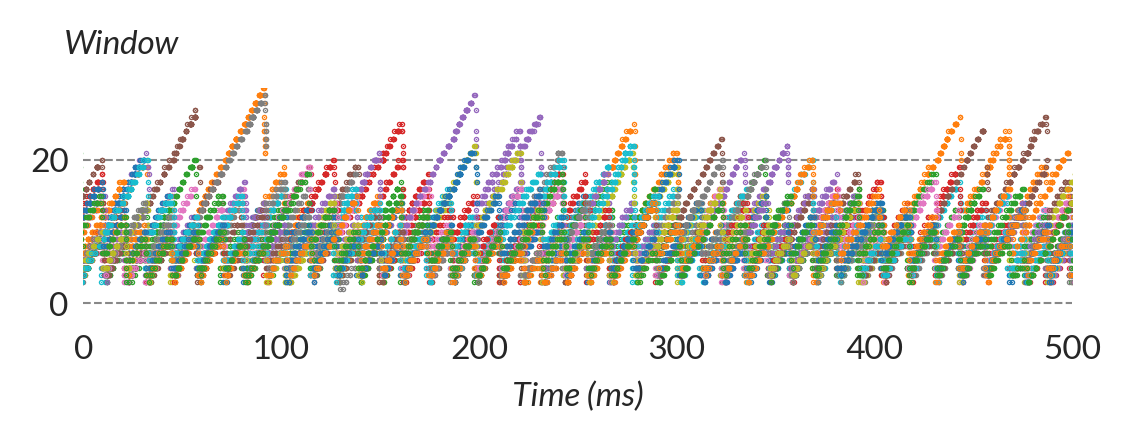

In [11]:
plt.figure(figsize=(1*width, 1/3*width))    

xmax=500
    
tdf = window_trace[window_trace.action=="ecn"]
tdf = tdf[tdf.time < xmax]
    
for _,flow_df in window_trace[window_trace.action == "ecn"].groupby(["sport", "dport"]):
    plt.scatter(flow_df.time, flow_df.snd_cwnd, s=0.1)
plt.axis(xmin=0, ymax=30, xmax=xmax)
plt.xlabel("Time (ms)")
plt.ylabel("Window")
plorts.style_axis()

plorts.savefig("../figures/traces/ecn_synchronized_windows.png")

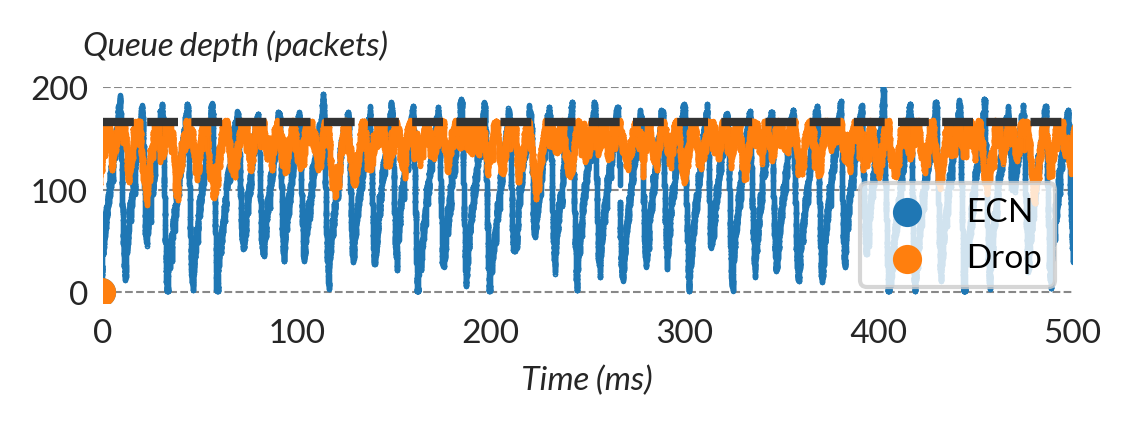

In [12]:
plt.figure(figsize=(width, 1/3*width))    
    
ecn = postcard_trace[postcard_trace.action == "ecn"]
drop = postcard_trace[postcard_trace.action == "drop"]

plt.scatter(ecn.time, ecn.queue_depth_packets, s=0.1, color='C0')
# hack to increase markersize in legend
plt.scatter([-1], [0], color='C0', label='ECN')
            
plt.scatter(drop.time, drop.queue_depth_packets, s=0.1, color='C1')
plt.scatter([-1], [0], color='C1', label='Drop')

plorts.legend(loc='lower right')

plt.axis(xmin=0, ymax=200,xmax=500)
plt.axhline(y=ecn.iloc[0].max_queue_depth_packets, color='#333333', linestyle='--')
plt.xlabel("Time (ms)")
plt.ylabel("Queue depth (packets)")
plorts.style_axis()

plorts.savefig("../figures/traces/ecn_synchronized.png")